### Import Lib

In [1]:
import numpy as np
import pandas as pd 
import os
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

#for visualization
import matplotlib.pyplot as plt
from PIL import  Image
%matplotlib inline
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.subplots as tls
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
#Read Data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
#Data Manupilation
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
df = df[df["TotalCharges"].notnull()]
df =df.reset_index()[df.columns]
df['TotalCharges']= df['TotalCharges'].astype(float)

replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    df[i]  = df[i].replace({'No internet service' : 'No'})

    
df["SeniorCitizen"] = df["SeniorCitizen"].replace({1:"Yes",0:"No"})

def tenure_lab(df) :
    
    if df["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (df["tenure"] > 12) & (df["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (df["tenure"] > 24) & (df["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (df["tenure"] > 48) & (df["tenure"] <= 60) :
        return "Tenure_48-60"
    elif df["tenure"] > 60 :
        return "Tenure_gt_60"
df["tenure_group"] = df.apply(lambda df:tenure_lab(df),
                                      axis = 1)

churn     = df[df["Churn"] == "Yes"]
not_churn = df[df["Churn"] == "No"]


In [4]:
Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]

In [5]:
val= df["Churn"].value_counts().values.tolist()
lab= df["Churn"].value_counts().keys().tolist()

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#customer id col
Id_col     = ['customerID']
#Target columns
target_col = ["Churn"]
#categorical columns
cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = df.nunique()[df.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

In [7]:
### Preprocessing

le = LabelEncoder()
for i in bin_cols :
    df[i] = le.fit_transform(df[i])
    
#Duplicating columns for multi value columns
df = pd.get_dummies(data = df,columns = multi_cols )
std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = df.copy()
df = df.drop(columns = num_cols,axis = 1)
df = df.merge(scaled,left_index=True,right_index=True,how = "left")

In [8]:
trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'purple' ,'pink'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 0,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Customer attrition in data (Total Customer From Database)",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

In [9]:
churn['gender'].value_counts().values.tolist()

[939, 930]

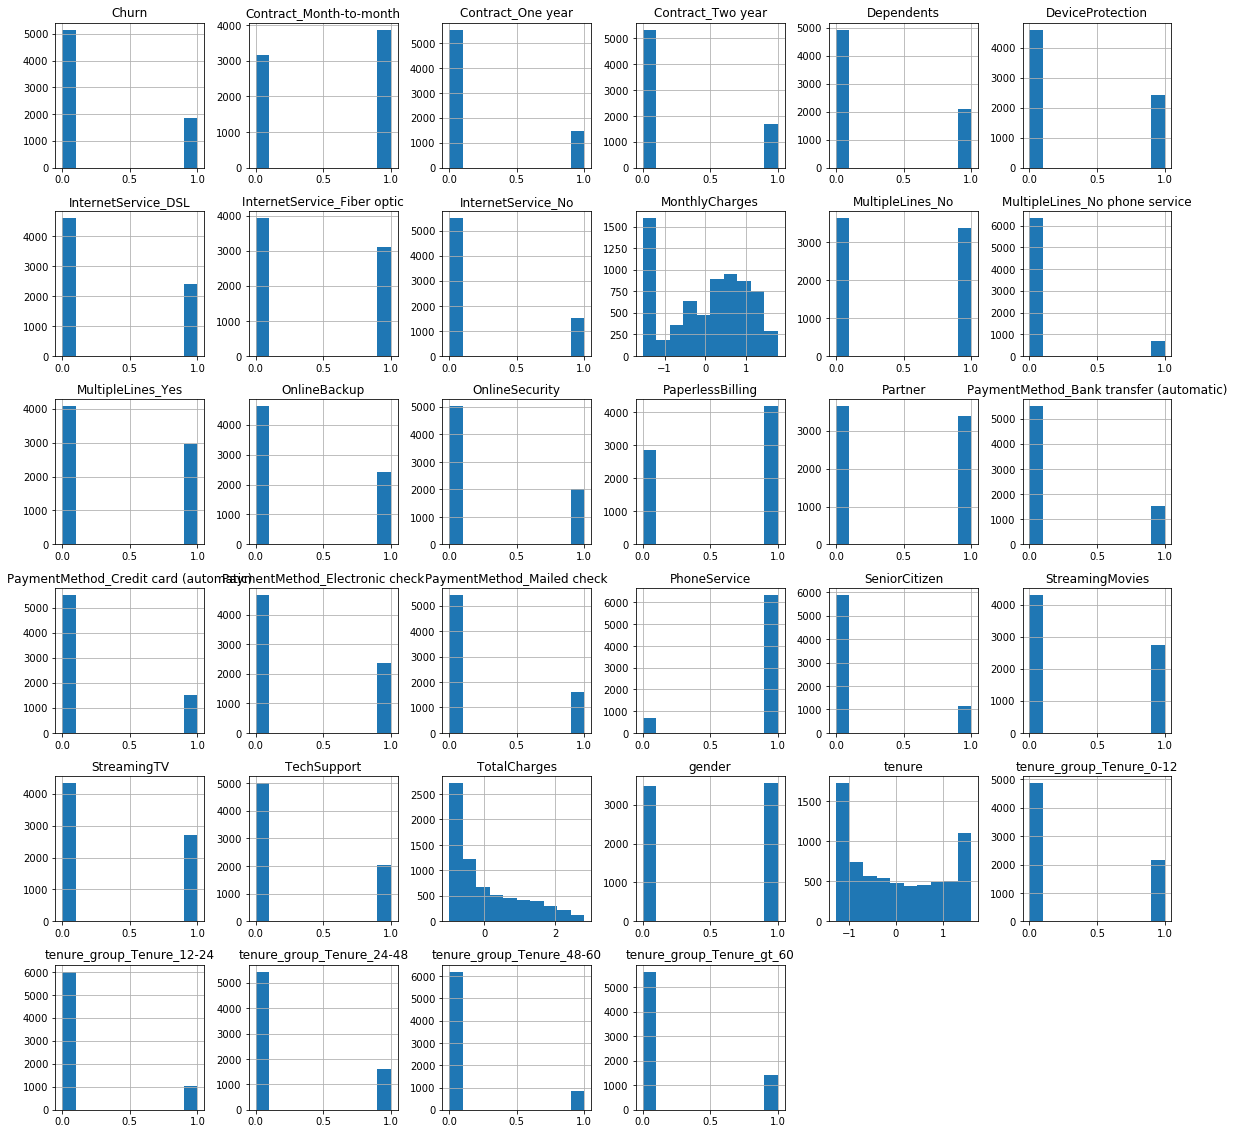

In [10]:
df.hist(figsize=(20,20))
plt.show()

In [11]:
df['gender'].value_counts()

1    3549
0    3483
Name: gender, dtype: int64

In [13]:
print("Churned Cust based on Gender in the dataset: Male = {:.1f}%; Female {:.1f}%.".format((df[(df['Churn'] == 1) & (
    df['gender'] == 1)].shape[0] / df[df['gender'] == 1].shape[0])*100, (df[(df['Churn'] == 1) & (df['gender'] == 0)].shape[0] / df[df['gender'] == 0].shape[0])*100))

df_Gender = pd.DataFrame(columns=["Gender", "% of Leavers"])
i=0
for field in list(df['gender'].unique()):
    ratio = df[(df['gender']==field)&(df['Churn']=="Yes")].shape[0] / df[df['gender']==field].shape[0]
    df_Gender.loc[i] = (field, ratio*100)
    i += 1
      
a = df_Gender.groupby(by="Gender").sum()
a.iplot(kind='bar',title='Leavers by Gender (%)')

Churned Cust based on Gender in the dataset: Male = 26.2%; Female 27.0%.


AttributeError: 'DataFrame' object has no attribute 'iplot'